In [31]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RYGate

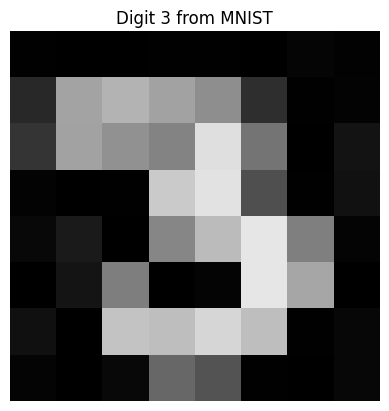

In [32]:
image = utils.plot_image('images/three_8by8.jpg', 'Digit 3 from MNIST')

In [33]:
def equal_superposition(circ: qiskit.QuantumCircuit, targets: int):
    for idx in range(targets): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: str):
    for idx, color in enumerate(intensity):
        if int(color):
            circ.mcx(
                control_qubits=control,
                target_qubit=target + idx
            )
    

In [34]:
def construct_neqr(circ: qiskit.QuantumCircuit, control: list, 
                   target: qiskit.QuantumRegister, image: np.array):
    
    num_qubits = circ.num_qubits
    num_intensity_qubits = 8
    num_idx_qubits = num_qubits -8

    # Identity for  intensity qubits.
    for idx in range(num_qubits):
        circ.id(idx)
    
    # Hadamard for index qubits.
    for idx in range(num_intensity_qubits, num_qubits):
        circ.h(idx)
        
    flat_img = image.flatten()
    num_pixels = len(flat_img)
    
    for idx, pixel in enumerate(flat_img):
        pixel_val = "{0:b}".format(pixel).zfill(num_intensity_qubits)
        pixel_pos = "{0:b}".format(idx).zfill(num_idx_qubits)
        
        for i, coord in enumerate(pixel_pos):
            if int(coord):
                circ.x(num_qubits-i-1) # I think I could reverse the string and remove the -i-1
                
        for j, val in enumerate(pixel_val[::-1]):
            if int(val):
                control = list(range(num_intensity_qubits, num_qubits))
                target = j
                circ.mcx(control_qubits=control,
                         target_qubit=target)
        
        if idx < num_pixels:
            for k, coord in enumerate(pixel_pos):
                if int(coord):
                    circ.x(num_qubits-k-1) 
        circ.barrier()   
    
    to_measure = [*range(num_qubits)]
    circ.measure(to_measure, to_measure)    
    

In [35]:
flat_ang_rep = utils.get_angle_representation(image,
                                                min_val=0,
                                                max_val=255)

n = int(log(image.shape[0], 2))

idx_reg = qiskit.QuantumRegister(2 * n, 'Index')
intensity_reg = qiskit.QuantumRegister(8, "Intensity") # Color intensity 2^8 -> (0, 255)
creg = qiskit.ClassicalRegister(2 * n + 8, 'bits')
neqr_circuit = qiskit.QuantumCircuit(intensity_reg, idx_reg, creg)

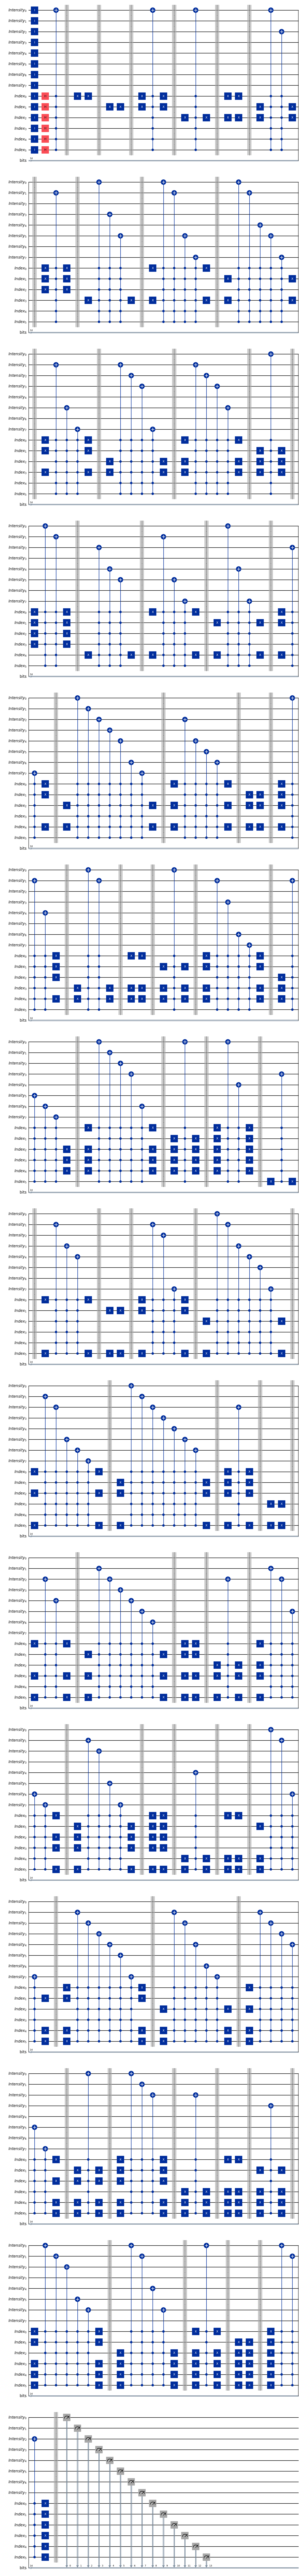

In [36]:
construct_neqr(neqr_circuit, None, None, image)
neqr_circuit.draw(output='mpl')

In [37]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(neqr_circuit, simulator)
shots = 1000
result = simulator.run(circuit, shots=shots).result()

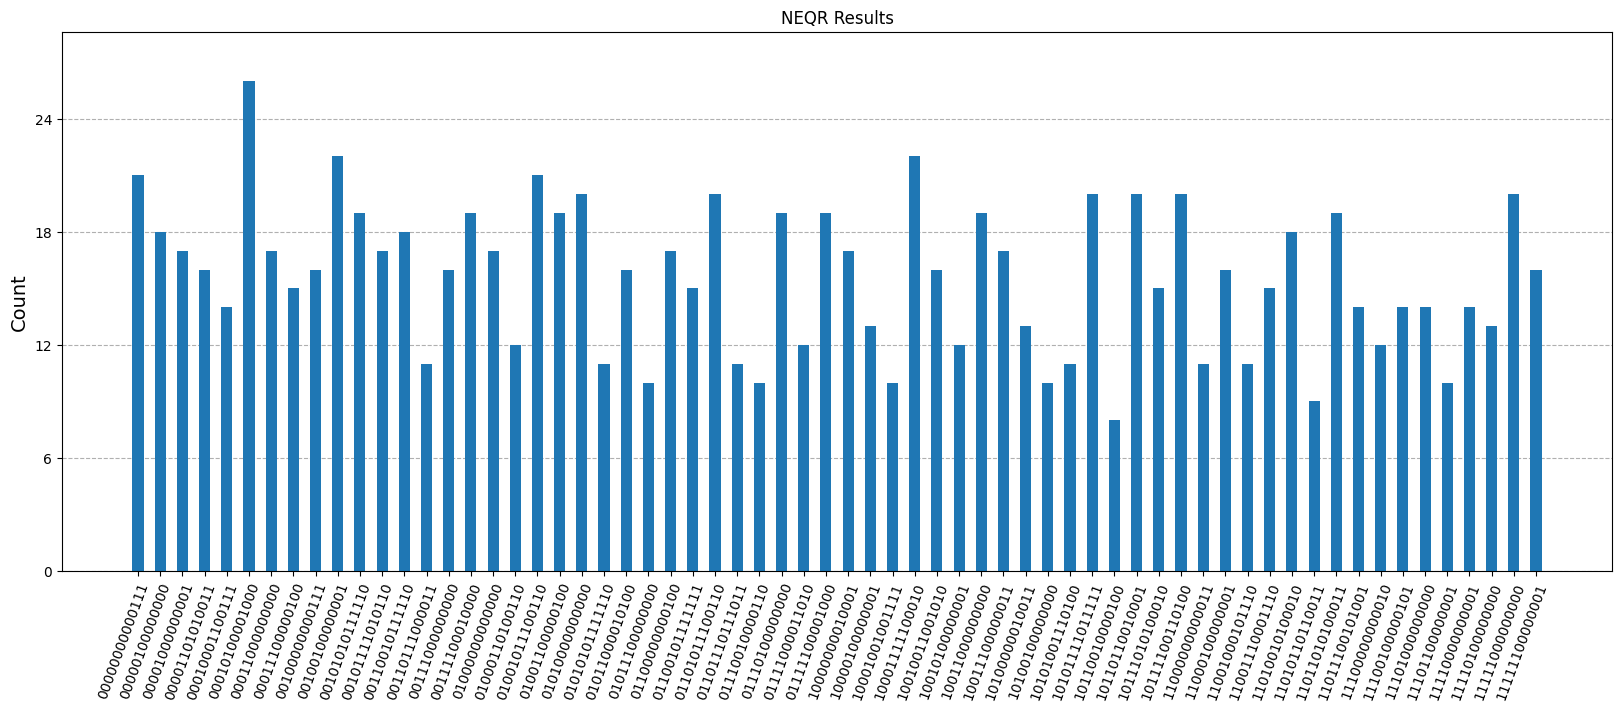

In [38]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="NEQR Results", bar_labels=False)

In [39]:
x = int(np.ceil(log(image.shape[1],2)))
y = int(np.ceil(log(image.shape[0],2)))

out_pixels = []
for item in counts:
    item = item.zfill(x + y)
    out_pixels.append((int(item[0:x+y], 2), int(item[x+y:],2)))

out_image = np.zeros((1, len(flat_ang_rep)))

for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]

out_image = np.fliplr(np.flipud(np.array(out_image).reshape(image.shape)))

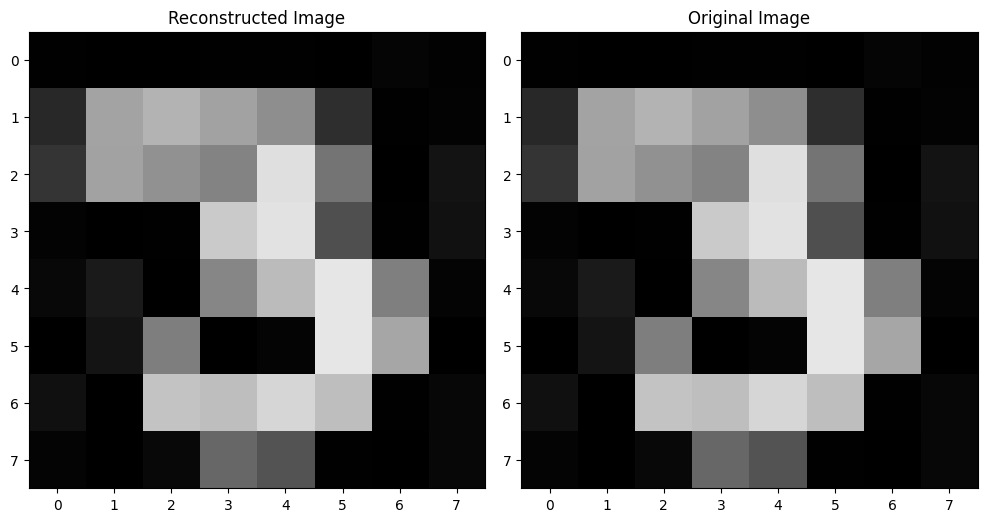

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(out_image, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()